In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('lyrics2.csv')

df['ranker_genre'] = np.where(
    (df['ranker_genre'] == 'screamo')|
    (df['ranker_genre'] == 'punk rock')|
    (df['ranker_genre'] == 'heavy metal'), 
    'alt rock', 
    df['ranker_genre']
)

In [11]:
group = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']
lyrics_by_song = df.sort_values(group)\
        .groupby(group).lyric\
        .apply(' '.join)\
        .apply(lambda x: x.lower())\
        .reset_index(name='lyric')

lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')

In [12]:
from tokennick import tokenizer

In [13]:
lyrics_by_song.ranker_genre.unique()

array(['Hip Hop', 'indie folk', 'rhythm and blues', 'alt rock',
       'classic rock'], dtype=object)

In [14]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords

genres = [
    'Country', 'alt rock', 'Hip Hop',
]

LYRIC_LEN = 400 # each song has to be  400 characters
N = 10000 # number of records to pull from each genre
RANDOM_SEED = 200 # random seed to make results repeatable

train_df = pd.DataFrame()
test_df = pd.DataFrame()
for genre in genres: # loop over each genre
    subset = lyrics_by_song[ # create a subset 
        (lyrics_by_song.ranker_genre==genre) & 
        (lyrics_by_song.lyric.str.len() > LYRIC_LEN)
    ]
    train_set = lyrics_by_song.sample(n=N, random_state=RANDOM_SEED)
    test_set = lyrics_by_song.drop(train_set.index)
    train_df = train_df.append(train_set) # append subsets to the master sets
    test_df = test_df.append(test_set)
    
train_df = shuffle(train_df)
test_df = shuffle(test_df)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# define our model
text_clf = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.6077082692898863

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.6328581309560406

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

stop = list(set(stopwords.words('english'))) # stopwords
wnl = WordNetLemmatizer() # lemmatizer

# def tokenizer(x): # custom tokenizer
#     return (
#         wnl.lemmatize(w) 
#         for w in word_tokenize(x) 
#         if len(w) > 2 and w.isalnum() # only words that are  2 characters
#     )                                 # and is alpha-numeric

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer(
        ngram_range=(1, 2), # include bigrams
        tokenizer=tokenizer,
        stop_words=stop,
        max_df=0.4, # ignore terms that appear in more than 40% of documents
        min_df=4)), # ignore terms that appear in less than 4 documents
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

/Users/brooklynpayne/anaconda3/envs/pandas/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.642253304641869

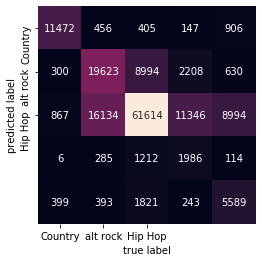

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(test_df.ranker_genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [19]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(test_df.ranker_genre, predicted)

for n,genre in enumerate(genres):
    genre = genre.upper()
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

COUNTRY_precision: 0.8570147915732855
COUNTRY_recall: 0.8794848206071757
COUNTRY_fscore: 0.8681044267877411
COUNTRY_support: 13044

ALT ROCK_precision: 0.6179499291450166
ALT ROCK_recall: 0.5319183540700984
ALT ROCK_fscore: 0.5717157591119657
ALT ROCK_support: 36891

HIP HOP_precision: 0.6226466575716235
HIP HOP_recall: 0.8321043675553035
HIP HOP_fscore: 0.7122964607141
HIP HOP_support: 74046



In [20]:
text_clf.predict(
    [
        "I dont give you cash i just get you high"
        "in my mind i will always be in love",
        "i stand for the red white and blue",
        "flow so smooth they say i rap in cursive",
        "take my heart and carve it out",
        "there is no end to the madness",
        "sitting on my front porch drinking sweet tea",
        "sitting on my front porch sippin on cognac",
        "dog died and my pick up truck wont start",
        "im invisible and the drugs wont help",
        "i hope you choke in your sleep thinking of me",
        "i wonder what genre a song about data science and naive bayes and hyper parameters and maybe a little scatter plots would be"
    ]
)

array(['Hip Hop', 'classic rock', 'Hip Hop', 'alt rock', 'alt rock',
       'classic rock', 'rhythm and blues', 'classic rock', 'alt rock',
       'classic rock', 'classic rock'], dtype='<U16')

In [9]:
from sklearn.externals import joblib
import _pickle as cPickle

joblib.dump(text_clf, 'finalproject3.pkl', compress = 1)

/Users/brooklynpayne/anaconda3/envs/pandas/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['finalproject3.pkl']

In [ ]:
newpipeline = joblib.load('finalproject2.pkl')

In [ ]:
newpipeline.predict(
    [
    
    "in my mind i will always be in love"
        
    ]

)